In [1]:
#Imports necesarios

import numpy as np
from torch import nn
import torch
import time
import pickle as pk
from torch.utils.data import DataLoader
import os
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

save_dir = 'C:/Users/nfier/Documents/Magister/cursos/EL7006 Redes Neuronales y Teoría de Información para el Aprendizaje/proyecto/'

class StampDataset(Dataset):
    def __init__(self, images, features, onehot, transform=None):  # Added transform argument
        self.img = images
        self.features = features
        self.labels = onehot
        self.transform = transform  # Store the transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img = self.img[idx,:,:,:]
        
        # Apply the transform if it's provided
        if self.transform:
            img = self.transform(img)

        return img, self.features[idx,:], self.labels[idx]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


In [3]:
#Carga de datos
with open(save_dir + "stamp_dataset_21_new.pkl", "rb") as f:
    data = pk.load(f)


#Separacion de los datos
Train_dict = data['Train']
Validation_dict = data['Validation']
train_images = Train_dict['images']
validation_images = Validation_dict['images']
labels_train = Train_dict['class']
labels_val = Validation_dict['class']
features_train = Train_dict['features']
features_val = Validation_dict['features']



transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


#Carga del dataset
train_dataset = StampDataset(np.transpose(train_images,[0,3,1,2]),features_train,labels_train)
val_dataset = StampDataset(np.transpose(validation_images,[0,3,1,2]),features_val,labels_val)

In [4]:

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [5]:
for batch in dataloader:
  example=batch
  break

In [6]:
example[0][0].shape

torch.Size([3, 21, 21])

DCGAN

In [7]:
from IPython import display
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0); # Set for testing purposes, please do not change!

In [8]:
# If you have multiple devices and just want to use one,
# then uncomment the following two lines:
# i_device = 1
# device = 'cuda:{0}'.format(i_device)
# Otherwise, uncomment the following line:
device = 'cuda'

In [9]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 21, 21), save=False, name=None, epoch=None):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()

    # Iterate through each channel
    for channel in range(size[0]):
        channel_images = image_unflat[:, channel:channel+1, :, :]
        image_grid = make_grid(channel_images[:num_images], nrow=5)
        
        plt.figure()
        plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap='gray')
        plt.axis('off')
        if save:
            plt.savefig('{}_channel_{}_epoch_{}.png'.format(name, channel, epoch))
        plt.show()

In [10]:
def make_gen_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(output_channels),nn.ReLU()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
            nn.Tanh()
        )

In [11]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            make_gen_block(self.z_dim,hidden_dim*4,kernel_size=3,stride=2),
            make_gen_block(hidden_dim*4,hidden_dim*2,kernel_size=4,stride=1),
            make_gen_block(hidden_dim*2,hidden_dim,kernel_size=3,stride=2),
            make_gen_block(hidden_dim,im_chan,kernel_size=4,stride=2,final_layer=True)
        )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [13]:
gen = Generator(im_chan=3)
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [14]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 3, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Well done !")

Well done !


In [15]:
def make_disc_block(input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
                nn.BatchNorm2d(output_channels),nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride)

            )

In [16]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            make_disc_block(im_chan,hidden_dim,kernel_size=3,stride=2),
            make_disc_block(hidden_dim,hidden_dim*2),
            make_disc_block(hidden_dim*2,1,final_layer=True)
        )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [17]:
num_test = 100

gen = Generator(im_chan=3)
disc = Discriminator(im_chan=3)
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = make_disc_block(3, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = make_disc_block(3, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [18]:
# UNIT TESTS
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block
assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Well done !")

Well done !


In [19]:
gen = Generator(z_dim,im_chan=3).to(device).float()
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator(im_chan=3).to(device).float()
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [20]:
x_entropy = nn.BCEWithLogitsLoss()

def get_gen_loss(disc_fake_pred):
    ### YOUR CODE HERE ###
    label = torch.ones(disc_fake_pred.size()[0], 1).to(device)
    gen_loss =  x_entropy(disc_fake_pred.squeeze(), label.squeeze())
    return gen_loss

def get_disc_loss(disc_fake_pred, disc_real_pred):
    ### YOUR CODE HERE ###
    real_label = torch.ones(disc_real_pred.size()[0], 1).to(device)
    fake_label = torch.zeros(disc_fake_pred.size()[0], 1).to(device)
    disc_loss = x_entropy(disc_fake_pred.squeeze(),fake_label.squeeze())+ x_entropy(disc_real_pred.squeeze(),real_label.squeeze())
    return disc_loss

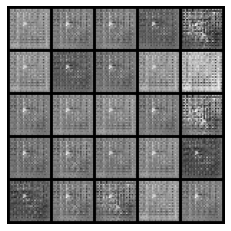

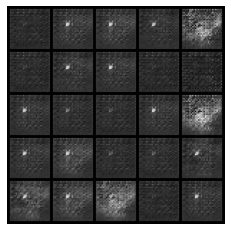

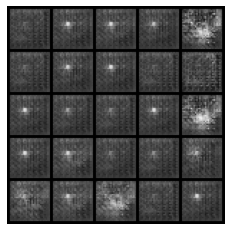

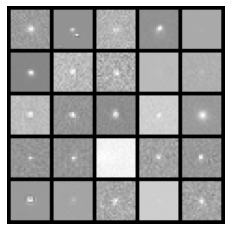

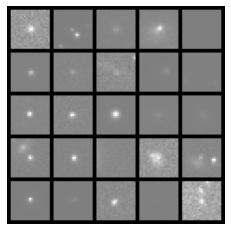

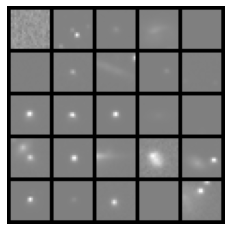

In [21]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    for img, features, onehot in tqdm(dataloader):  # Modified this line to account for the three returned values
        cur_batch_size = len(img)
        img = img.to(device).float()  # Use the image

        # Update discriminator
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_real_pred = disc(img)  # Use the image
        disc_loss = get_disc_loss(disc_fake_pred, disc_real_pred)

        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        # Update generator
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = get_gen_loss(disc_fake_pred)
        gen_loss.backward()
        gen_opt.step()
        mean_generator_loss += gen_loss.item() / display_step

        # Visualization code
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            display.clear_output(wait=True)
            show_tensor_images(fake, save=True, epoch=epoch, name='outputs/astro_vanilla_dc_gan')
            show_tensor_images(img)  # Use the image
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


In [22]:
# Here you can either save or load a trained model
name = 'dcgan_astro'
torch.save(gen.state_dict(), name)
# gen.load_state_dict(torch.load('dcgan'))